In [37]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import importlib

In [38]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [39]:
# Hyperparameters 
nn_name = 'data/NeuralModel.pth'
svm_name = 'data/svm.pth'
train_model_svm = True
train_model_NN = True

save_model_svm = True
save_model_NN = True

use_saved_svm = not train_model_svm
use_saved_NN = not train_model_NN

In [40]:
# Hyperparameters for colored
c_nn_name = 'data/c_NeuralModel.pth'
c_svm_name = 'data/c_svm.pth'
c_train_model_svm = True
c_train_model_NN = True

c_save_model_svm = True
c_save_model_NN = True

c_use_saved_svm = not c_train_model_svm
c_use_saved_NN = not c_train_model_NN

In [41]:
loss_mean_number = 1000
batch_size = 100
data_size = 60000

In [42]:
loss_fn = nn.CrossEntropyLoss()

In [43]:

def train_loop(train_dataloader, model, loss_fn, optimizer):
    model.train()
    train_loss = 0
    num_batches = len(train_dataloader)
    for batch, (X, y) in enumerate(train_dataloader):
        X = X.type(torch.FloatTensor).to(device=device)
        # Compute prediction and loss
        pred = model(X)
        #create a tearget vector
        t = torch.zeros([batch_size,10], device=device)
        for i, yy in enumerate(y):
            t[i][yy] = 1
        #calculate loss
        loss = loss_fn(pred,t)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Train loss
        train_loss += loss.item()
    return train_loss / num_batches



In [44]:
def test_loop(test_dataloader, model, loss_fn):

    num_batches = len(test_dataloader)
    accuracy = 0
    test_loss = 0

    with torch.no_grad():
        for X, y in test_dataloader:
            X = X.type(torch.FloatTensor).to(device=device)
            pred = model(X)
            t = torch.zeros([batch_size,10], device=device)
            for i, yy in enumerate(y):
                t[i][yy] = 1
            test_loss += loss_fn(pred, t).item()
            y = y.to(device)
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()

    return test_loss/ num_batches, accuracy / num_batches


In [45]:
def epoch_loop(test, train, model, loss, optimizer, epoch_number=10):
    train_loss_list= []
    test_loss_list = []
    accuracy_list = []
    for epoch in range(epoch_number):
        test_loss, accuracy = test_loop(test, model, loss)
        train_loss = train_loop(train, model, loss, optimizer)
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        accuracy_list.append(accuracy)
        print(f'for epoch {epoch} : accuracy = {accuracy}')
        print(f'test_loss= {test_loss} train_loss={train_loss}')
        print('-'*10)
    return train_loss_list, test_loss_list, accuracy_list

In [46]:
def graph(accuracy, train_loss, test_loss):
    train_loss_list =  np.array(train_loss).flatten()
    test_loss_list = np.array(test_loss).flatten()
    accuracy_list = np.array(accuracy).flatten()
    e1 = len(train_loss_list)
    e2 = len(test_loss_list)
    x1 = np.array([x for x in range(e1)])
    x2 = np.array([x for x in range(e2)])
    fig, (ax1,ax2) = plt.subplots(2,1, sharex=True)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    ax1.plot(x1, train_loss_list)
    ax3 = ax2.twinx()
    ax2.plot(x2, test_loss_list)
    ax1.set_ylabel('Train loss')
    ax2.set_ylabel('Test Loss')
    ax3.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax3.plot(x2, accuracy_list, color='orange')
    ax3.yaxis.set_major_locator(ticker.MaxNLocator())
    ax3.yaxis.set_minor_locator(ticker.AutoMinorLocator())

# MNIST 

In [6]:
class SVM(nn.Module):
    def __init__(self):
        super(SVM, self).__init__()
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(28*28, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.mlp(x)
        return logits

if use_saved_svm:
    svm_model = torch.load(svm_name).to(device)
else:
    svm_model = SVM().to(device)

In [7]:
# Define MLP model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(28*28, 120),
            nn.ReLU(),
            nn.Linear(120, 90),
            nn.ReLU(),
            nn.Linear(90, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.mlp(x)
        return F.softmax(logits, dim=1)

if use_saved_NN:
    NN_model = torch.load(nn_name).to(device)
else:
    NN_model = NeuralNetwork().to(device)

In [8]:
optimizer_NN = torch.optim.Adam(NN_model.parameters())
optimizer_svm = torch.optim.Adam(svm_model.parameters())

In [10]:
mnist_train = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
)

mnist_test = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
)


/home/erd/.local/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [11]:
# Create data loaders.
train_dataloader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([100, 1, 28, 28])
Shape of y:  torch.Size([100]) torch.int64


for epoch 0 : accuracy = 14.65
test_loss= 2.302518079280853 train_loss=1.6173233373959859
----------
for epoch 1 : accuracy = 92.87
test_loss= 1.5371686708927155 train_loss=1.5299067217111588
----------
for epoch 2 : accuracy = 93.8
test_loss= 1.5269020557403565 train_loss=1.514894859790802
----------
for epoch 3 : accuracy = 95.27
test_loss= 1.510397824048996 train_loss=1.5053806680440902
----------
for epoch 4 : accuracy = 95.81
test_loss= 1.5053792357444764 train_loss=1.4992540820439657
----------
for epoch 5 : accuracy = 96.12
test_loss= 1.5010007452964782 train_loss=1.4943008557955424
----------
for epoch 6 : accuracy = 96.18
test_loss= 1.500785528421402 train_loss=1.490594932238261
----------
for epoch 7 : accuracy = 96.69
test_loss= 1.4961233425140381 train_loss=1.4873536690076192
----------
for epoch 8 : accuracy = 96.9
test_loss= 1.49354705452919 train_loss=1.4851465046405792
----------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


for epoch 9 : accuracy = 96.44
test_loss= 1.4981571185588836 train_loss=1.483295007944107
----------


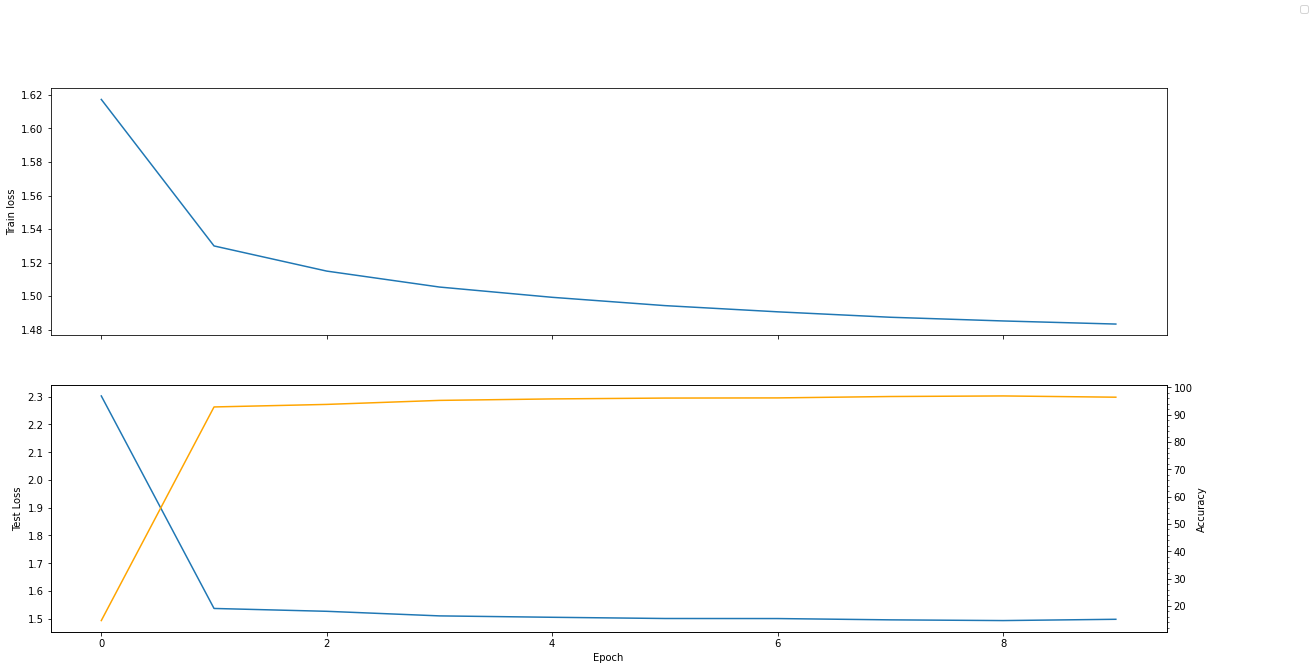

In [17]:
if train_model_NN:
    train_loss, test_loss, accuracy = epoch_loop(test_dataloader, train_dataloader, NN_model, loss_fn, optimizer_NN, epoch_number=10)
    graph(accuracy, train_loss, test_loss)
    if save_model_NN:
        torch.save(NN_model, nn_name)

In [18]:
if train_model_svm:
    train_loss, test_loss, accuracy_list = epoch_loop(test_dataloader, train_dataloader, svm_model, loss_fn,optimizer_svm)
    if save_model_svm:
        torch.save(svm_model, svm_name)


for epoch 0 : accuracy = 7.44
test_loss= 2.329030110836029 train_loss=0.619049892971913
----------
for epoch 1 : accuracy = 90.42
test_loss= 0.36121049150824547 train_loss=0.344559086188674
----------
for epoch 2 : accuracy = 91.38
test_loss= 0.3087589952349663 train_loss=0.3087111909687519
----------
for epoch 3 : accuracy = 91.79
test_loss= 0.2923202519863844 train_loss=0.29184522669762375
----------
for epoch 4 : accuracy = 92.13
test_loss= 0.27870191134512423 train_loss=0.281536458345751
----------
for epoch 5 : accuracy = 92.43
test_loss= 0.2743033898621798 train_loss=0.27440097083648046
----------
for epoch 6 : accuracy = 92.32
test_loss= 0.2729883848130703 train_loss=0.26915721721947194
----------
for epoch 7 : accuracy = 92.61
test_loss= 0.26807804077863695 train_loss=0.2647636562337478
----------
for epoch 8 : accuracy = 92.37
test_loss= 0.267855364009738 train_loss=0.26190800638248524
----------
for epoch 9 : accuracy = 92.72
test_loss= 0.26474200546741483 train_loss=0.258941

TypeError: graph() missing 1 required positional argument: 'epoch_number'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


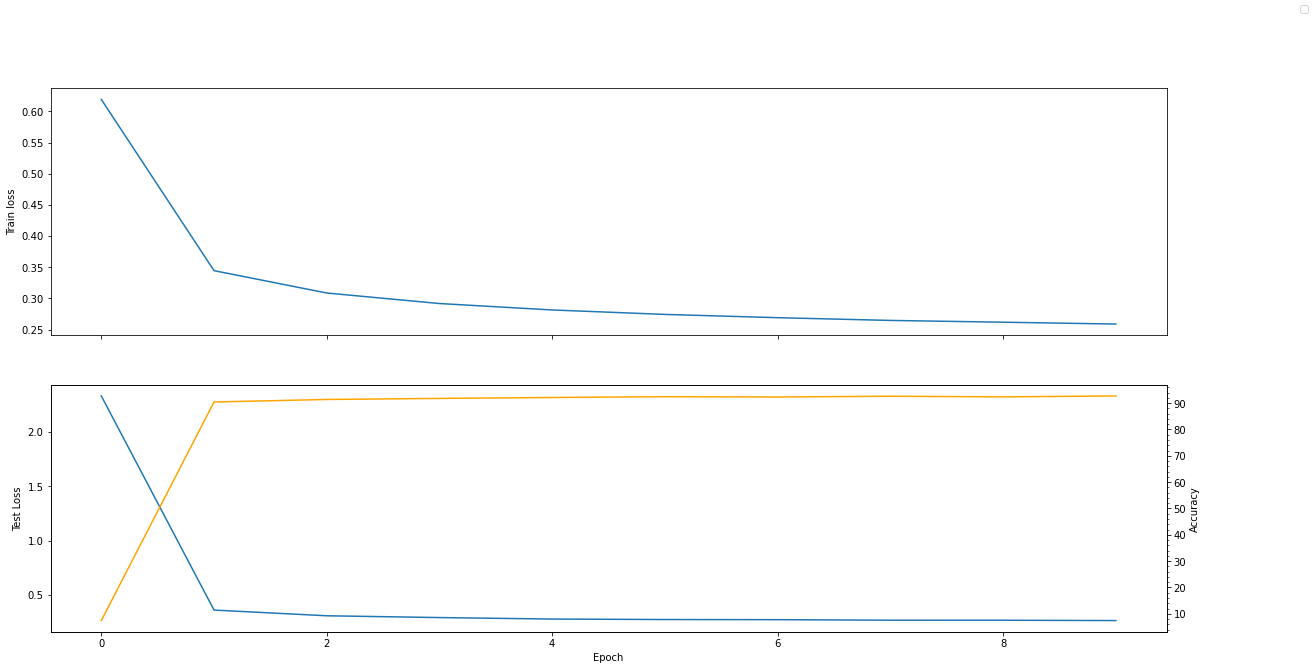

In [22]:
if train_model_svm:
    graph(accuracy_list, train_loss, test_loss)

# Colored MNIST

In [67]:
import colored_mnist
importlib.reload(colored_mnist)

<module 'colored_mnist' from '/home/erd/code/FIZ437E/HW3/colored_mnist.py'>

In [68]:
cmnist_train = colored_mnist.coloredMNIST('data/colored_MNIST/',test=False)
cmnist_test = colored_mnist.coloredMNIST('data/colored_MNIST/',test=True)

In [69]:
print(cmnist_test.data.shape)
print(cmnist_train.data.shape)

torch.Size([10000, 28, 28, 3])
torch.Size([60000, 28, 28, 3])


In [70]:
class c_SVM(nn.Module):
    def __init__(self):
        super(c_SVM, self).__init__()
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(3 * 28*28, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.mlp(x)
        return logits

if c_use_saved_svm:
    c_svm_model = torch.load(c_svm_name).to(device)
else:
    c_svm_model = c_SVM().to(device)

In [71]:
# Define MLP model
class c_NeuralNetwork(nn.Module):
    def __init__(self):
        super(c_NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(3 * 28*28, 120),
            nn.ReLU(),
            nn.Linear(120, 90),
            nn.ReLU(),
            nn.Linear(90, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.mlp(x)
        return F.softmax(logits, dim=1)

if c_use_saved_NN:
    c_NN_model = torch.load(c_nn_name).to(device)
else:
    c_NN_model = c_NeuralNetwork().to(device)

In [72]:
# Create data loaders.
c_train_dataloader = DataLoader(cmnist_train, batch_size=batch_size, shuffle=True)
c_test_dataloader = DataLoader(cmnist_test, batch_size=batch_size, shuffle=True)

In [73]:
c_optimizer_NN = torch.optim.Adam(c_NN_model.parameters())
c_optimizer_svm = torch.optim.Adam(c_svm_model.parameters())

In [74]:
if c_train_model_NN:
    train_loss, test_loss, accuracy_list = epoch_loop(c_train_dataloader, c_test_dataloader, c_NN_model, loss_fn, c_optimizer_NN)
    if c_save_model_NN:
        torch.save(c_NN_model, c_nn_name)

IndexError: index 16342 is out of bounds for dimension 0 with size 10000